In [95]:
import re
import json

In [96]:
with open('../../generated_material/first_louvain_run/com0_coms_between2010_and_2015.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('../../generated_material/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [97]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [98]:
import re
import numpy as np
import pandas as pd 

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

In [99]:
articles_df = pd.DataFrame(data)
articles_df.dropna(inplace=True)
articles_df.head()

,ID_Article,communityId,ID_RelatedVenue,title,year,abstract
0,2673736,15226,30,CIDI-lung-seg: a single-click annotation tool ...,2014,Accurate and fast extraction of lung volumes f...
1,2727060,15226,30,Novel wireless-communicating textiles made fro...,2014,The ability to integrate multiple materials in...
2,2549308,14040,30,"A Wearable, Wireless Gaze Tracker with Integra...",2011,"A light-weight, wearable, wireless gaze tracke..."
3,2553223,15226,30,A RESTful Image Gateway for Multiple Medical I...,2012,Mobile technologies are increasingly important...
4,2489547,15226,30,Adaptive Beat-to-Beat Heart Rate Estimation in...,2011,A ballistocardiograph records the mechanical a...


In [100]:
articles_df['communityId'].value_counts()

15226    14646
13990    14131
14010     9793
14125     9772
14133     8628
15258     6891
14127     4919
15237     4848
15517     4693
14040     4684
15514     4370
14018     4152
15510     2690
Name: communityId, dtype: int64

In [101]:
# Input Community to perform analysis on
community_id_to_use = 15510

In [102]:
df_articles_ofCom = articles_df[articles_df['communityId'] == community_id_to_use]
df_articles_ofCom.head()

,ID_Article,communityId,ID_RelatedVenue,title,year,abstract
56,2224993,15510,30,Design and Evaluation of a Telemonitoring Conc...,2012,Utilization of information and communication t...
172,1452319,15510,30,ECG-Cryptography and Authentication in Body Ar...,2012,Wireless body area networks (BANs) have drawn ...
243,897316,15510,30,Analysis of Using Interpulse Intervals to Gene...,2012,"Wireless body sensor network (WBSN), a key bui..."
971,2230990,15510,122,ZOOMM: a parallel web browser engine for multi...,2013,We explore the challenges in expressing and ma...
1106,2417886,15510,208,Covert DCF: A DCF-Based Covert Timing Channel ...,2011,Covert communications have been used for many ...


display articles in the community disributed by the year they were published in and see if any patterns can be found

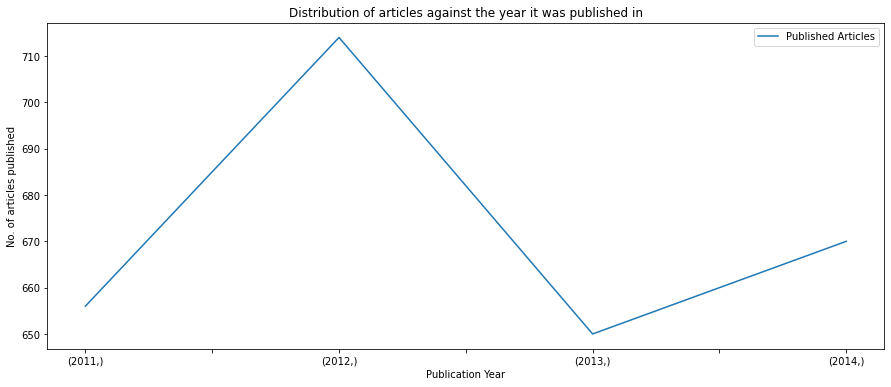

In [103]:
ax = df_articles_ofCom[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of articles against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of articles published')
plt.legend(["Published Articles"])

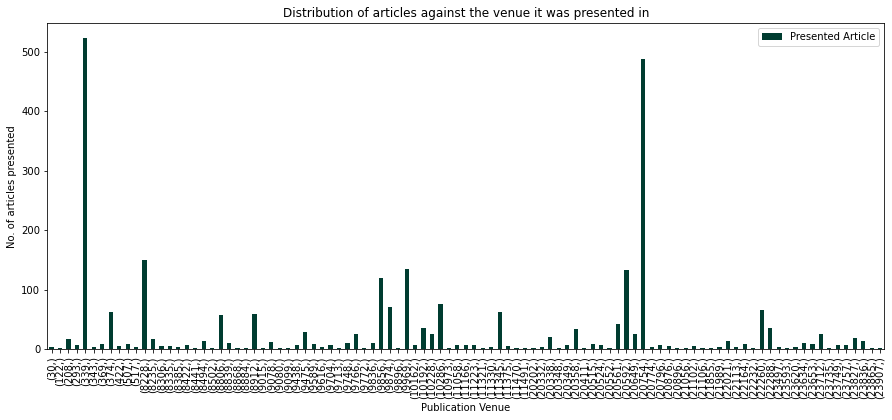

In [104]:
ax = df_articles_ofCom[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of articles against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of articles presented')
plt.legend(["Presented Article"])

In [105]:
print(conference_data_dict[9078])
print(conference_data_dict[390])

international conference on image processing
international symposium on biomedical imaging


In [106]:
titles_df = pd.DataFrame()

## Analysis on the titles of the articles

text preprocessing
1. Removing unwanted characters
2. Casting to lower case
3. Tokenization
4. Removing stop_words
5. Lemmatization

In [107]:
stop_words.update(['based', 'using', 'A', 'The'])

titles_df['processed_words'] = df_articles_ofCom.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: row['processed_words'].lower(), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: (word_tokenize(row['processed_words'])), axis = 1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([w for w in row['processed_words'] if w not in stop_words]), axis=1)
titles_df['processed_words'] = titles_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['processed_words']]), axis=1)
titles_df['concatenated_words'] = titles_df.apply(lambda row: ' '.join(row['processed_words']), axis=1)
all_titles = ' '.join(titles_df['concatenated_words'].str.lower())

Next we take a look at top 30 words and the number of times they have been used in the article titles.

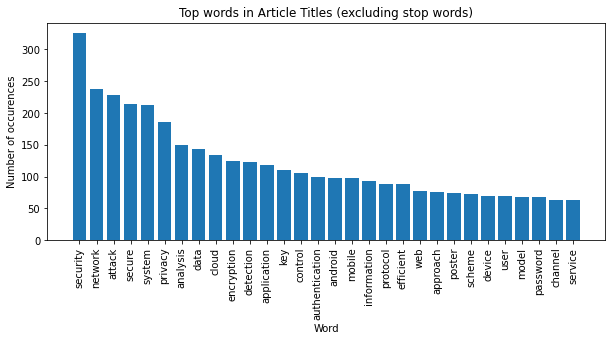

In [108]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=titles_df['concatenated_words'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Article Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the articles

In [109]:
dictionary = corpora.Dictionary(titles_df['processed_words'])
texts = titles_df['processed_words']
corpus = [dictionary.doc2bow(text) for text in texts]

In [110]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [111]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

### Article titles with maximum correspondence to the top topic words.

In [112]:
titles = titles_df['concatenated_words'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_titles = tfidf_vectorizer.transform(counts)

In [113]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_titles)
lda_W = lda_model.transform(tfidf_titles)
lda_H = lda_model.components_

## Analysis on the Abstracts of the Articles

In [114]:
abstracts_df = pd.DataFrame()

stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
abstracts_df['processed_words'] = df_articles_ofCom.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
abstracts_df['processed_words'] = abstracts_df.apply(lambda row: (re.sub(latex_regex, "", row['processed_words'])),axis=1)
abstracts_df['processed_words'] = abstracts_df.apply(lambda row: row['processed_words'].lower(), axis = 1)
abstracts_df['processed_words'] = abstracts_df.apply(lambda row: (word_tokenize(row['processed_words'])), axis = 1)
abstracts_df['processed_words'] = abstracts_df.apply(lambda row: ([w for w in row['processed_words'] if w not in stop_words]), axis=1)
abstracts_df['processed_words'] = abstracts_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['processed_words']]), axis=1)
abstracts_df['concatenated_words'] = abstracts_df.apply(lambda row: ' '.join(row['processed_words']), axis=1)

In [126]:
pd.options.display.max_colwidth = 150
print(df_articles_ofCom['abstract'])
print(abstracts_df)

56        Utilization of information and communication technologies such as mobile phones and wireless sensor networks becomes more and more common in the f...
172       Wireless body area networks (BANs) have drawn much attention from research community and industry in recent years. Multimedia healthcare services ...
243       Wireless body sensor network (WBSN), a key building block for m-Health, demands extremely stringent resource constraints and thus lightweight secu...
971       We explore the challenges in expressing and managing concurrency in browsers on mobile devices. Browsers are complex applications that implement m...
1106      Covert communications have been used for many decades. Accordingly, when digital communications moved to the forefront it was natural that covert ...
                                                                                  ...                                                                          
105380    BGP prefix hijacking remains a

pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

In [158]:
abstracts = abstracts_df['concatenated_words'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
tf_abstracts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(tf_abstracts)
tfidf_abstracts = tfidf_vectorizer.transform(tf_abstracts)

In [131]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
abstracts_doc_topic_distr = lda_model.transform(tfidf_abstracts)
abstracts_topic_word_distr = lda_model.components_

In [132]:
def display_topics(topic_word_distr, doc_topic_distr, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(topic_word_distr):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( doc_topic_distr[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Article Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df_articles_ofCom['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(abstracts_topic_word_distr, abstracts_doc_topic_distr, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  call record, password field, threat probability, malware encounter, oasis, spm, passsec, password field user, cluster obtained, security analytics, field user, powerline, nist sp800, openflow verification, sp800

Article Titles:
Beheading hydras: performing effective botnet takedowns
POSTER: How Distributed Are Today's DDoS Attacks?
Statistical Properties of Pseudo Random Sequences and Experiments with PHP and Debian OpenSSL
Verification of switching network properties using satisfiability

****************************************************************************************************
TOPIC 1:
Top Words:  nullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnullnulln

In [118]:
def get_representative_articles(topic_word_distr, doc_topic_distr, no_top_documents):
    representatives_df = pd.DataFrame()
    # For each topic get n top docs sorted desc by their value
    for topic_idx, topic in enumerate(topic_word_distr):
        # Sort and reverse the list of the document distribution and slice it to no_top_documents
        top_doc_indices = np.argsort( doc_topic_distr[:,topic_idx] )[::-1][0:no_top_documents]
        # Add each of the top docs to a new representatives dataframe
        for doc_index in top_doc_indices:
            representatives_df = representatives_df.append(df_articles_ofCom.iloc[doc_index])
    return representatives_df

no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representatives_df = get_representative_articles(abstracts_topic_word_distr, abstracts_doc_topic_distr, no_top_documents)
representatives_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representatives_df[col] = representatives_df[col].astype('int')

<!-- representatives_df.to_csv("../representatives/firstRun/repr_" + str(community_id_to_use) + ".csv", index=False)
representatives_df -->

In [119]:
# representative_df.to_csv("../representatives/firstRun/repr_" + str(community_id_to_use) + ".csv", index=False)
# representative_df